## 1. Shared Setup: Imports & Configuration


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set your data root here (e.g., MINDsmall_train)
NOTEBOOK_DIR = Path(os.getcwd())
DATA_ROOT = NOTEBOOK_DIR / 'MINDsmall_train'

NEWS_PATH = DATA_ROOT / 'news.tsv'
BEHAVIORS_PATH = DATA_ROOT / 'behaviors.tsv'


## 2. Shared Data Loader & Interaction Construction


In [3]:
def load_mind_data(news_path: Path = NEWS_PATH,
                   behaviors_path: Path = BEHAVIORS_PATH):
    """Load MIND-style news and behaviors files.

    Returns:
        news_df: news metadata
        behaviors_df: raw behaviors with impression strings
        interactions_df: flattened (user, news, label, time) rows
    """
    news_df = pd.read_csv(
        news_path,
        sep='\t',
        header=None,
        names=['news_id', 'category', 'subcategory', 'title', 'abstract',
               'url', 'title_entities', 'abstract_entities'],
        on_bad_lines='skip'
    )

    behaviors_df = pd.read_csv(
        behaviors_path,
        sep='\t',
        header=None,
        names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
        on_bad_lines='skip'
    )

    # Flatten impressions into (user, news, label, time)
    rows = []
    for _, row in behaviors_df.iterrows():
        uid = row['user_id']
        ts = row['time']
        imps = str(row['impressions']).split()
        for imp in imps:
            try:
                nid, label = imp.split('-')
                rows.append({
                    'user_id': uid,
                    'news_id': nid,
                    'label': int(label),
                    'time': ts
                })
            except ValueError:
                # Skip malformed impressions
                continue

    interactions_df = pd.DataFrame(rows)
    interactions_df['time'] = pd.to_datetime(interactions_df['time'], errors='coerce')
    interactions_df = interactions_df.sort_values('time').reset_index(drop=True)

    return news_df, behaviors_df, interactions_df


news_df, behaviors_df, interactions_df = load_mind_data()
print(f"News: {len(news_df):,} articles")
print(f"Interactions: {len(interactions_df):,} rows")
print(f"Users: {interactions_df['user_id'].nunique():,}")


News: 51,282 articles
Interactions: 5,843,444 rows
Users: 50,000


## 3. Chronological Train / Dev / Test Split


In [4]:
def chrono_train_dev_test_split(interactions: pd.DataFrame,
                               train_ratio: float = 0.7,
                               dev_ratio: float = 0.15):
    """Chronologically split interactions into train / dev / test.

    Splits by timestamp to avoid leakage from future into past.
    """
    interactions = interactions.sort_values('time').reset_index(drop=True)
    n = len(interactions)
    train_end = int(n * train_ratio)
    dev_end = int(n * (train_ratio + dev_ratio))

    train = interactions.iloc[:train_end].reset_index(drop=True)
    dev = interactions.iloc[train_end:dev_end].reset_index(drop=True)
    test = interactions.iloc[dev_end:].reset_index(drop=True)

    return train, dev, test


train_interactions, dev_interactions, test_interactions = chrono_train_dev_test_split(interactions_df)
print(f"Train: {len(train_interactions):,}")
print(f"Dev:   {len(dev_interactions):,}")
print(f"Test:  {len(test_interactions):,}")


Train: 4,090,410
Dev:   876,517
Test:  876,517


## 4. Evaluation Metrics (Hit Rate, MRR, NDCG, Precision, Recall, Coverage)


In [5]:
def hit_rate_at_k(labels, scores, k=5):
    order = np.argsort(scores)[::-1][:k]
    return 1.0 if np.any(np.array(labels)[order] == 1) else 0.0


def mrr(labels, scores):
    order = np.argsort(scores)[::-1]
    labels = np.array(labels)[order]
    for rank, lab in enumerate(labels, start=1):
        if lab == 1:
            return 1.0 / rank
    return 0.0


def dcg_at_k(labels, scores, k=5):
    order = np.argsort(scores)[::-1][:k]
    labels = np.array(labels)[order]
    gains = (2 ** labels - 1) / np.log2(np.arange(2, len(labels) + 2))
    return gains.sum()


def ndcg_at_k(labels, scores, k=5):
    ideal_labels = np.sort(labels)[::-1]
    ideal_dcg = dcg_at_k(ideal_labels, ideal_labels, k)
    if ideal_dcg == 0:
        return 0.0
    return dcg_at_k(labels, scores, k) / ideal_dcg


def precision_recall_at_k(labels, scores, k=5):
    order = np.argsort(scores)[::-1][:k]
    labels = np.array(labels)
    selected = labels[order]
    tp = selected.sum()
    prec = tp / k
    rec = tp / (labels.sum() + 1e-8)
    return prec, rec


def f1_from_pr(prec, rec):
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)


def coverage(recommended_items, all_items):
    rec_items = set(recommended_items)
    return len(rec_items) / max(1, len(all_items))


## 5. Content-Based Filtering: Training & Evaluation


In [6]:
# Content-Based Filtering Implementation
# This section implements the full content-based filtering system
# Adapted from content_based.ipynb

from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score
from collections import defaultdict

# Parse impressions function
def parse_impressions(impression_str):
    """Parse impression string format: 'N123-1 N456-0' -> (items, labels)"""
    if pd.isna(impression_str) or impression_str == '':
        return [], []
    items, labels = [], []
    for pair in str(impression_str).split():
        try:
            nid, lbl = pair.split('-')
            items.append(nid)
            labels.append(int(lbl))
        except ValueError:
            continue
    return items, labels

# Preprocess news: combine title and abstract
news_df['text'] = news_df['title'].fillna('') + ' ' + news_df['abstract'].fillna('')
news_df = news_df[news_df['text'].str.strip() != ''].copy()

# Create TF-IDF vectorizer (using same parameters as content_based.ipynb)
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit TF-IDF on training news
news_tfidf = vectorizer.fit_transform(news_df['text'])
news_index = {nid: i for i, nid in enumerate(news_df['news_id'])}

print(f"TF-IDF shape: {news_tfidf.shape}, Vocabulary: {len(vectorizer.vocabulary_):,}")

# Build user click history from train interactions
user_clicked = defaultdict(list)
for _, row in train_interactions[train_interactions['label'] == 1].iterrows():
    user_clicked[row['user_id']].append(row['news_id'])

# Remove duplicates
for uid in user_clicked:
    user_clicked[uid] = list(dict.fromkeys(user_clicked[uid]))

# Build article popularity for cold-start fallback
article_popularity = {}
for _, row in train_interactions[train_interactions['label'] == 1].iterrows():
    nid = row['news_id']
    article_popularity[nid] = article_popularity.get(nid, 0) + 1

if article_popularity:
    max_pop = max(article_popularity.values())
    article_popularity = {k: v / max_pop for k, v in article_popularity.items()}

# User profile construction
def get_user_vector(user_id):
    """Build user profile by averaging TF-IDF vectors of clicked articles."""
    clicked = user_clicked.get(user_id, [])
    idxs = [news_index[n] for n in clicked if n in news_index]
    if len(idxs) == 0:
        return None
    profile = news_tfidf[idxs].mean(axis=0)
    return np.asarray(profile).flatten()

# Scoring function
def score_impression_content_based(impression_row):
    """Score articles using cosine similarity to user profile + popularity fallback."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    uvec = get_user_vector(uid)
    scores = np.zeros(len(items))
    
    # Content-based scoring
    if uvec is not None:
        idxs, positions = [], []
        for i, news_id in enumerate(items):
            if news_id in news_index:
                idxs.append(news_index[news_id])
                positions.append(i)
        
        if idxs:
            item_vecs = news_tfidf[idxs]
            content_sims = cosine_similarity(uvec.reshape(1, -1), item_vecs).flatten()
            for pos, sim in zip(positions, content_sims):
                scores[pos] = sim
    
    # Popularity fallback
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.5
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores



TF-IDF shape: (51282, 5000), Vocabulary: 5,000


In [7]:
# Scoring function for dev set (handles both train and dev articles)
def score_impression_content_based_dev(impression_row, train_news_index, dev_news_index, 
                                      train_news_tfidf, dev_news_tfidf):
    """Score dev articles handling both train and dev sets."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    uvec = get_user_vector(uid)
    scores = np.zeros(len(items))
    
    if uvec is not None:
        train_idxs, dev_idxs, train_positions, dev_positions = [], [], [], []
        for i, news_id in enumerate(items):
            if news_id in train_news_index:
                train_idxs.append(train_news_index[news_id])
                train_positions.append(i)
            elif news_id in dev_news_index:
                dev_idxs.append(dev_news_index[news_id])
                dev_positions.append(i)
        
        if train_idxs:
            train_sims = cosine_similarity(uvec.reshape(1, -1), train_news_tfidf[train_idxs]).flatten()
            for pos, sim in zip(train_positions, train_sims):
                scores[pos] = sim
        
        if dev_idxs:
            dev_sims = cosine_similarity(uvec.reshape(1, -1), dev_news_tfidf[dev_idxs]).flatten()
            for pos, sim in zip(dev_positions, dev_sims):
                scores[pos] = sim
    
    # Popularity fallback
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.5
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores

# Evaluation function (matching content_based.ipynb format)
def evaluate_content_based_recommendations(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate on dev dataset."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    precision_scores = []
    f1_scores = []
    recall_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression_content_based_dev(row, news_index, dev_news_index, news_tfidf, dev_news_tfidf)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
        
        # Compute precision, recall, and F1 at top-5
        top_5_labels = labels[top_5_indices]
        top_5_predictions = np.ones_like(top_5_labels)
        precision_scores.append(precision_score(top_5_labels, top_5_predictions, zero_division=0))
        recall_scores.append(recall_score(top_5_labels, top_5_predictions, zero_division=0))
        f1_scores.append(f1_score(top_5_labels, top_5_predictions, zero_division=0))
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Precision @ 5': np.mean(precision_scores) if precision_scores else 0.0,
        'Recall @ 5': np.mean(recall_scores) if recall_scores else 0.0,
        'F1 @ 5': np.mean(f1_scores) if f1_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Load dev dataset
DEV_DATA_ROOT = NOTEBOOK_DIR / 'MINDsmall_dev'
dev_news = pd.read_csv(
    DEV_DATA_ROOT / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)
dev_behaviors = pd.read_csv(
    DEV_DATA_ROOT / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dev dataset: {len(dev_news):,} articles, {len(dev_behaviors):,} impressions, {dev_behaviors['user_id'].nunique():,} users")

# Preprocess dev news
dev_news['text'] = dev_news['title'].fillna('') + ' ' + dev_news['abstract'].fillna('')
dev_news = dev_news[dev_news['text'].str.strip() != ''].copy()

# Parse dev impressions
dev_behaviors['imp_items'], dev_behaviors['imp_labels'] = zip(
    *dev_behaviors['impressions'].apply(parse_impressions)
)

# Transform dev news using training vectorizer
dev_news_tfidf = vectorizer.transform(dev_news['text'])
dev_news_index = {nid: i for i, nid in enumerate(dev_news['news_id'])}
print(f"Dev TF-IDF matrix shape: {dev_news_tfidf.shape}")

# Check dev users with training history
dev_users_with_history = sum(1 for uid in dev_behaviors['user_id'].unique() if uid in user_clicked)
print(f"Dev users with training history: {dev_users_with_history:,} / {dev_behaviors['user_id'].nunique():,} ({dev_users_with_history/dev_behaviors['user_id'].nunique()*100:.1f}%)")

# Evaluate on dev set
dev_metrics = evaluate_content_based_recommendations(dev_behaviors, sample_size=None, random_seed=42)
print("Dev Set Results:")
for metric, value in dev_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

# Convert to unified format
content_based_dev_metrics = {
    'HR@k': dev_metrics['Hit Rate @ 1'],
    'MRR': dev_metrics['MRR'],
    'NDCG@k': dev_metrics['NDCG @ 5'],
    'Precision@k': dev_metrics['Precision @ 5'],
    'Recall@k': dev_metrics['Recall @ 5'],
    'F1@k': dev_metrics['F1 @ 5'],
    'Coverage': dev_metrics['Coverage']
}

content_based_dev_metrics


Dev dataset: 42,416 articles, 73,152 impressions, 50,000 users
Dev TF-IDF matrix shape: (42416, 5000)
Dev users with training history: 5,314 / 50,000 (10.6%)
Dev Set Results:
  Hit Rate @ 1: 0.0891
  MRR: 0.2148
  NDCG @ 5: 0.2929
  AUC: 0.5053
  Precision @ 5: 0.0817
  Recall @ 5: 0.3259
  F1 @ 5: 0.1276
  Coverage: 78.96%
  Total Evaluated: 57,763


{'HR@k': 0.08905354638782612,
 'MRR': 0.21480984196782565,
 'NDCG@k': 0.2929239285958798,
 'Precision@k': 0.08173427049610765,
 'Recall@k': 0.32590066305420423,
 'F1@k': 0.12759432426260672,
 'Coverage': 0.7896298118985127}

## 6. User-Based Collaborative Filtering: Training & Evaluation


In [8]:
# User-Based Collaborative Filtering Implementation
# This section implements the full user-based collaborative filtering system
# Adapted from user_based.ipynb

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score
from collections import defaultdict

# Parse impressions function
def parse_impressions(impression_str):
    """Parse impression string format: 'N123-1 N456-0' -> (items, labels)"""
    if pd.isna(impression_str) or impression_str == '':
        return [], []
    items, labels = [], []
    for pair in str(impression_str).split():
        try:
            nid, lbl = pair.split('-')
            items.append(nid)
            labels.append(int(lbl))
        except ValueError:
            continue
    return items, labels

# Build user click history from train interactions
user_clicked = defaultdict(list)
for _, row in train_interactions[train_interactions['label'] == 1].iterrows():
    user_clicked[row['user_id']].append(row['news_id'])

# Remove duplicates
for uid in user_clicked:
    user_clicked[uid] = list(dict.fromkeys(user_clicked[uid]))

# Build article popularity for cold-start fallback
article_popularity = {}
for _, row in train_interactions[train_interactions['label'] == 1].iterrows():
    nid = row['news_id']
    article_popularity[nid] = article_popularity.get(nid, 0) + 1

if article_popularity:
    max_pop = max(article_popularity.values())
    article_popularity = {k: v / max_pop for k, v in article_popularity.items()}

# Create user-item interaction matrix
all_users = sorted(list(user_clicked.keys()))
all_articles = sorted(list(set().union(*[set(clicks) for clicks in user_clicked.values()])))

user_to_idx = {uid: i for i, uid in enumerate(all_users)}
article_to_idx = {aid: i for i, aid in enumerate(all_articles)}

# Build sparse matrix
row_indices = []
col_indices = []
data = []

for uid, clicked_articles in user_clicked.items():
    user_idx = user_to_idx[uid]
    for article_id in clicked_articles:
        if article_id in article_to_idx:
            col_idx = article_to_idx[article_id]
            row_indices.append(user_idx)
            col_indices.append(col_idx)
            data.append(1.0)

user_item_matrix = csr_matrix((data, (row_indices, col_indices)), 
                              shape=(len(all_users), len(all_articles)))

print(f"User-Item matrix shape: {user_item_matrix.shape}")
print(f"Matrix density: {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.6f}")

# Compute user-user similarity matrix using cosine similarity
print("Computing user-user similarity matrix...")
user_similarity = cosine_similarity(user_item_matrix)
print(f"User similarity matrix shape: {user_similarity.shape}")

# Store top-k similar users for each user (for efficiency)
top_k_similar = 50  # Number of similar users to consider
user_similar_users = {}

for i, uid in enumerate(all_users):
    # Get similarities for this user (excluding self)
    similarities = user_similarity[i].copy()
    similarities[i] = -1  # Exclude self
    
    # Get top-k similar users
    top_indices = np.argsort(similarities)[::-1][:top_k_similar]
    user_similar_users[uid] = [(all_users[idx], similarities[idx]) 
                                for idx in top_indices if similarities[idx] > 0]

print(f"Computed similar users for {len(user_similar_users):,} users")

# Scoring function
def score_impression_user_based(impression_row):
    """Score articles using user-based collaborative filtering."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    scores = np.zeros(len(items))
    
    # Get similar users
    if uid not in user_similar_users:
        # Cold-start: use popularity
        for i, news_id in enumerate(items):
            scores[i] = article_popularity.get(news_id, 0.0) * 0.5
        return scores
    
    similar_users = user_similar_users[uid]
    if len(similar_users) == 0:
        # No similar users: use popularity
        for i, news_id in enumerate(items):
            scores[i] = article_popularity.get(news_id, 0.0) * 0.5
        return scores
    
    # Aggregate scores from similar users
    # Weight by similarity and normalize
    for i, news_id in enumerate(items):
        score_sum = 0.0
        similarity_sum = 0.0
        
        for similar_uid, similarity in similar_users:
            if similarity > 0 and similar_uid in user_clicked:
                if news_id in user_clicked[similar_uid]:
                    score_sum += similarity
                similarity_sum += abs(similarity)
        
        if similarity_sum > 0:
            scores[i] = score_sum / similarity_sum
    
    # Add popularity fallback for articles with no similar user clicks
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.3
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores


User-Item matrix shape: (43758, 5750)
Matrix density: 0.000667
Computing user-user similarity matrix...
User similarity matrix shape: (43758, 43758)
Computed similar users for 43,758 users


In [9]:
# Evaluation function (matching user_based.ipynb format)
def evaluate_user_based_recommendations(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate recommendation system using multiple metrics."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    precision_scores = []
    f1_scores = []
    recall_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression_user_based(row)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
        
        # Compute precision, recall, and F1 at top-5
        top_5_labels = labels[top_5_indices]
        top_5_predictions = np.ones_like(top_5_labels)
        precision_scores.append(precision_score(top_5_labels, top_5_predictions, zero_division=0))
        recall_scores.append(recall_score(top_5_labels, top_5_predictions, zero_division=0))
        f1_scores.append(f1_score(top_5_labels, top_5_predictions, zero_division=0))
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Precision @ 5': np.mean(precision_scores) if precision_scores else 0.0,
        'Recall @ 5': np.mean(recall_scores) if recall_scores else 0.0,
        'F1 @ 5': np.mean(f1_scores) if f1_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Load dev dataset
DEV_DATA_ROOT = NOTEBOOK_DIR / 'MINDsmall_dev'
dev_behaviors = pd.read_csv(
    DEV_DATA_ROOT / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

# Parse dev impressions
dev_behaviors['imp_items'], dev_behaviors['imp_labels'] = zip(
    *dev_behaviors['impressions'].apply(parse_impressions)
)

# Check dev users with training history
dev_users_with_history = sum(1 for uid in dev_behaviors['user_id'].unique() if uid in user_similar_users)
print(f"Dev users with training history: {dev_users_with_history:,} / {dev_behaviors['user_id'].nunique():,} ({dev_users_with_history/dev_behaviors['user_id'].nunique()*100:.1f}%)")

# Evaluate on dev set
dev_metrics = evaluate_user_based_recommendations(dev_behaviors, sample_size=None, random_seed=42)
print("Dev Set Results:")
for metric, value in dev_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

# Convert to unified format
user_based_dev_metrics = {
    'HR@k': dev_metrics['Hit Rate @ 1'],
    'MRR': dev_metrics['MRR'],
    'NDCG@k': dev_metrics['NDCG @ 5'],
    'Precision@k': dev_metrics['Precision @ 5'],
    'Recall@k': dev_metrics['Recall @ 5'],
    'F1@k': dev_metrics['F1 @ 5'],
    'Coverage': dev_metrics['Coverage']
}

user_based_dev_metrics


Dev users with training history: 5,314 / 50,000 (10.6%)
Dev Set Results:
  Hit Rate @ 1: 0.0806
  MRR: 0.2034
  NDCG @ 5: 0.2771
  AUC: 0.4992
  Precision @ 5: 0.0774
  Recall @ 5: 0.3091
  F1 @ 5: 0.1209
  Coverage: 76.73%
  Total Evaluated: 56,126


{'HR@k': 0.08060435448811602,
 'MRR': 0.20344699337498565,
 'NDCG@k': 0.2770543388854566,
 'Precision@k': 0.07742014990081839,
 'Recall@k': 0.3091437123614724,
 'F1@k': 0.12091374339708444,
 'Coverage': 0.7672517497812773}

## 7. Clustering-Based Recommendation: Training & Evaluation


In [10]:
# Clustering-Based Recommendation Implementation
# This section implements the full clustering-based recommendation system
# Adapted from clustering.ipynb

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score
from scipy.sparse import csr_matrix
from collections import defaultdict

# Parse impressions function
def parse_impressions(impression_str):
    """Parse impression string format: 'N123-1 N456-0' -> (items, labels)"""
    if pd.isna(impression_str) or impression_str == '':
        return [], []
    items, labels = [], []
    for pair in str(impression_str).split():
        try:
            nid, lbl = pair.split('-')
            items.append(nid)
            labels.append(int(lbl))
        except ValueError:
            continue
    return items, labels

# Build user click history from train interactions
user_clicked = defaultdict(list)
for _, row in train_interactions[train_interactions['label'] == 1].iterrows():
    user_clicked[row['user_id']].append(row['news_id'])

# Remove duplicates
for uid in user_clicked:
    user_clicked[uid] = list(dict.fromkeys(user_clicked[uid]))

# Build article popularity for cold-start fallback
article_popularity = {}
for _, row in train_interactions[train_interactions['label'] == 1].iterrows():
    nid = row['news_id']
    article_popularity[nid] = article_popularity.get(nid, 0) + 1

if article_popularity:
    max_pop = max(article_popularity.values())
    article_popularity = {k: v / max_pop for k, v in article_popularity.items()}

# Create user-item interaction matrix
all_users = sorted(list(user_clicked.keys()))
all_articles = sorted(list(set().union(*[set(clicks) for clicks in user_clicked.values()])))

user_to_idx = {uid: i for i, uid in enumerate(all_users)}
article_to_idx = {aid: i for i, aid in enumerate(all_articles)}

# Build sparse matrix
row_indices = []
col_indices = []
data = []

for uid, clicked_articles in user_clicked.items():
    user_idx = user_to_idx[uid]
    for article_id in clicked_articles:
        if article_id in article_to_idx:
            col_idx = article_to_idx[article_id]
            row_indices.append(user_idx)
            col_indices.append(col_idx)
            data.append(1.0)

user_item_matrix = csr_matrix((data, (row_indices, col_indices)), 
                              shape=(len(all_users), len(all_articles)))

# Apply K-Means clustering
n_clusters = 50
print(f"Applying K-Means clustering with {n_clusters} clusters...")
user_item_dense = user_item_matrix.toarray()
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
user_clusters = kmeans.fit_predict(user_item_dense)

# Create mapping from user_id to cluster
user_to_cluster = {uid: user_clusters[i] for i, uid in enumerate(all_users)}

# Build cluster profiles: articles liked by users in each cluster
cluster_articles = {}
cluster_user_counts = {}

for i, uid in enumerate(all_users):
    cluster_id = user_clusters[i]
    if cluster_id not in cluster_articles:
        cluster_articles[cluster_id] = {}
        cluster_user_counts[cluster_id] = 0
    
    cluster_user_counts[cluster_id] += 1
    for article_id in user_clicked[uid]:
        if article_id in article_to_idx:
            cluster_articles[cluster_id][article_id] = cluster_articles[cluster_id].get(article_id, 0) + 1

# Normalize cluster article scores by cluster size
for cluster_id in cluster_articles:
    cluster_size = cluster_user_counts[cluster_id]
    if cluster_size > 0:
        cluster_articles[cluster_id] = {k: v / cluster_size for k, v in cluster_articles[cluster_id].items()}

print(f"Clustered {len(all_users):,} users into {n_clusters} clusters")

# Scoring function
def score_impression_clustering(impression_row):
    """Score articles using cluster-based recommendations."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    scores = np.zeros(len(items))
    
    # Get user's cluster
    if uid not in user_to_cluster:
        # Cold-start: use popularity
        for i, news_id in enumerate(items):
            scores[i] = article_popularity.get(news_id, 0.0) * 0.5
        return scores
    
    cluster_id = user_to_cluster[uid]
    cluster_profile = cluster_articles.get(cluster_id, {})
    
    # Score articles based on cluster profile
    for i, news_id in enumerate(items):
        cluster_score = cluster_profile.get(news_id, 0.0)
        scores[i] = cluster_score
    
    # Add popularity fallback for articles with no cluster support
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.3
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores

# Evaluation function (matching clustering.ipynb format)
def evaluate_clustering_recommendations(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate recommendation system using multiple metrics."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    precision_scores = []
    f1_scores = []
    recall_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression_clustering(row)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
        
        # Compute precision, recall, and F1 at top-5
        top_5_labels = labels[top_5_indices]
        top_5_predictions = np.ones_like(top_5_labels)
        precision_scores.append(precision_score(top_5_labels, top_5_predictions, zero_division=0))
        recall_scores.append(recall_score(top_5_labels, top_5_predictions, zero_division=0))
        f1_scores.append(f1_score(top_5_labels, top_5_predictions, zero_division=0))
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Precision @ 5': np.mean(precision_scores) if precision_scores else 0.0,
        'Recall @ 5': np.mean(recall_scores) if recall_scores else 0.0,
        'F1 @ 5': np.mean(f1_scores) if f1_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Load dev dataset
DEV_DATA_ROOT = NOTEBOOK_DIR / 'MINDsmall_dev'
dev_behaviors = pd.read_csv(
    DEV_DATA_ROOT / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

# Parse dev impressions
dev_behaviors['imp_items'], dev_behaviors['imp_labels'] = zip(
    *dev_behaviors['impressions'].apply(parse_impressions)
)

# Evaluate on dev set
dev_metrics = evaluate_clustering_recommendations(dev_behaviors, sample_size=None, random_seed=42)
print("Dev Set Results:")
for metric, value in dev_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

# Convert to unified format
clustering_dev_metrics = {
    'HR@k': dev_metrics['Hit Rate @ 1'],
    'MRR': dev_metrics['MRR'],
    'NDCG@k': dev_metrics['NDCG @ 5'],
    'Precision@k': dev_metrics['Precision @ 5'],
    'Recall@k': dev_metrics['Recall @ 5'],
    'F1@k': dev_metrics['F1 @ 5'],
    'Coverage': dev_metrics['Coverage']
}

clustering_dev_metrics


Applying K-Means clustering with 50 clusters...
Clustered 43,758 users into 50 clusters
Dev Set Results:
  Hit Rate @ 1: 0.0806
  MRR: 0.2034
  NDCG @ 5: 0.2771
  AUC: 0.4992
  Precision @ 5: 0.0774
  Recall @ 5: 0.3092
  F1 @ 5: 0.1209
  Coverage: 76.73%
  Total Evaluated: 56,126


{'HR@k': 0.08056872037914692,
 'MRR': 0.2034209254212525,
 'NDCG@k': 0.2770816119645697,
 'Precision@k': 0.07742371331171531,
 'Recall@k': 0.309161529415957,
 'F1@k': 0.12091968241524595,
 'Coverage': 0.7672517497812773}

## 8. Unified Comparison Table


In [11]:
metrics_list = ['HR@k', 'MRR', 'NDCG@k', 'Precision@k', 'Recall@k', 'F1@k', 'Coverage']

rows = []
for m in metrics_list:
    row = {
        'Metric': m,
        'Content-Based (Dev)': content_based_dev_metrics.get(m, np.nan),
        'User-Based (Dev)': user_based_dev_metrics.get(m, np.nan),
    }
    if clustering_dev_metrics is not None:
        row['Clustering (Dev)'] = clustering_dev_metrics.get(m, np.nan)
    rows.append(row)

comparison_df = pd.DataFrame(rows)
comparison_df


,Metric,Content-Based (Dev),User-Based (Dev),Clustering (Dev)
0,HR@k,0.089054,0.080604,0.080569
1,MRR,0.214810,0.203447,0.203421
2,NDCG@k,0.292924,0.277054,0.277082
3,Precision@k,0.081734,0.077420,0.077424
4,Recall@k,0.325901,0.309144,0.309162
5,F1@k,0.127594,0.120914,0.120920
6,Coverage,0.789630,0.767252,0.767252


## 9. Visualizations and Performance Comparison


/var/folders/4n/bdyxwmhd7zgcjmm4slq_sprc0000gn/T/ipykernel_49283/3768345426.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(metrics_to_plot, rotation=45, ha='right')


✓ Saved dev_heatmap.png
✓ Saved dev_performance_comparison.png


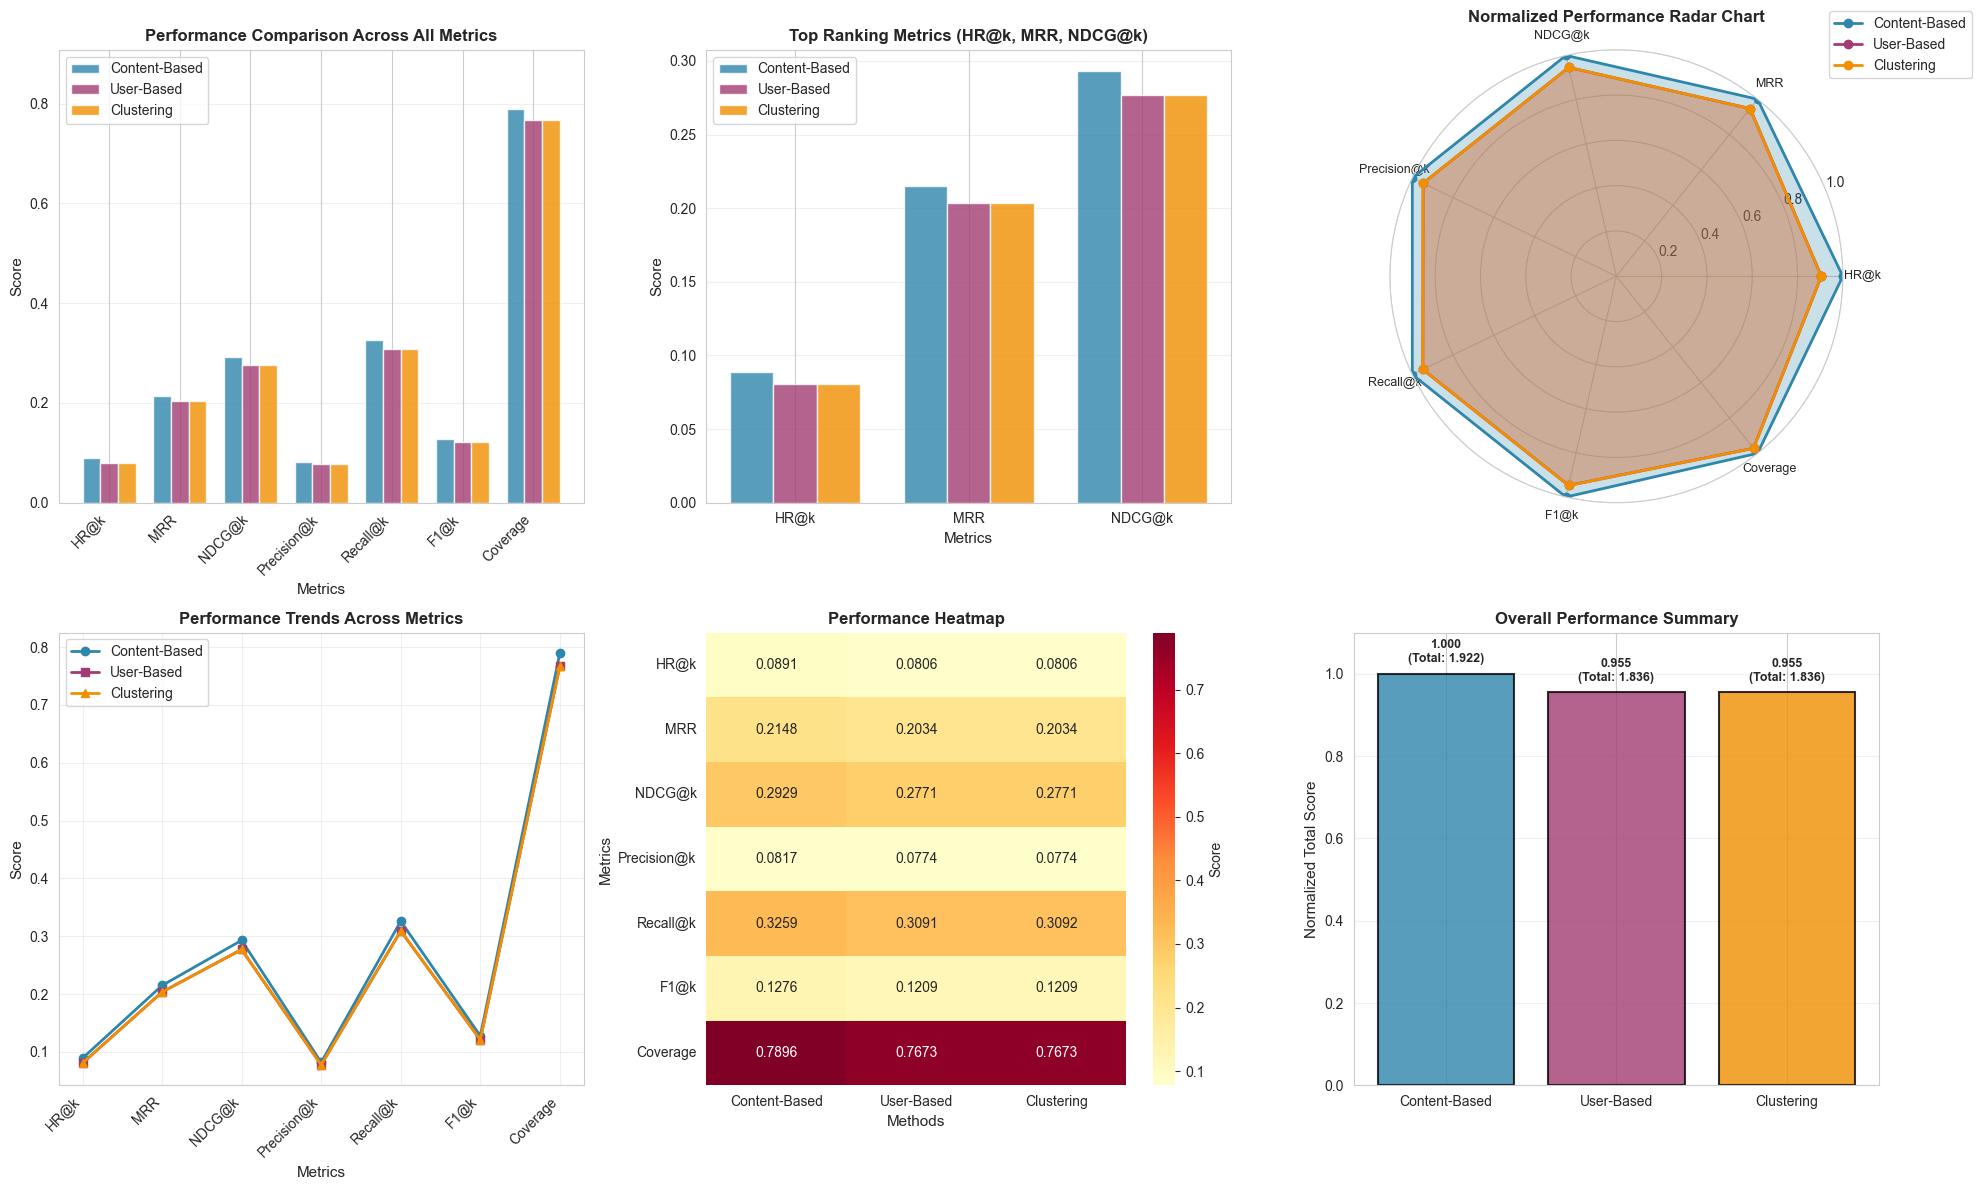


SUMMARY STATISTICS

Metric          Content-Based      User-Based         Clustering         Best Method    
--------------------------------------------------------------------------------
HR@k            0.0891             0.0806             0.0806             Content-Based  
MRR             0.2148             0.2034             0.2034             Content-Based  
NDCG@k          0.2929             0.2771             0.2771             Content-Based  
Precision@k     0.0817             0.0774             0.0774             Content-Based  
Recall@k        0.3259             0.3091             0.3092             Content-Based  
F1@k            0.1276             0.1209             0.1209             Content-Based  
Coverage        0.7896             0.7673             0.7673             Content-Based  

KEY INSIGHTS
• Best HR@k: 0.0891
• Best MRR: 0.2148
• Best NDCG@k: 0.2929
• Best Coverage: 0.7896


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

# Prepare data for visualization
metrics_to_plot = ['HR@k', 'MRR', 'NDCG@k', 'Precision@k', 'Recall@k', 'F1@k', 'Coverage']
methods = ['Content-Based', 'User-Based', 'Clustering']
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Extract values
content_values = [content_based_dev_metrics.get(m, 0) for m in metrics_to_plot]
user_values = [user_based_dev_metrics.get(m, 0) for m in metrics_to_plot]
clustering_values = [clustering_dev_metrics.get(m, 0) for m in metrics_to_plot]

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Bar Chart - Side by Side Comparison
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(metrics_to_plot))
width = 0.25
ax1.bar(x - width, content_values, width, label='Content-Based', color=colors[0], alpha=0.8)
ax1.bar(x, user_values, width, label='User-Based', color=colors[1], alpha=0.8)
ax1.bar(x + width, clustering_values, width, label='Clustering', color=colors[2], alpha=0.8)
ax1.set_xlabel('Metrics', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Performance Comparison Across All Metrics', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(max(content_values), max(user_values), max(clustering_values)) * 1.15])

# 2. Grouped Bar Chart - Top Metrics
ax2 = plt.subplot(2, 3, 2)
top_metrics = ['HR@k', 'MRR', 'NDCG@k']
top_content = [content_based_dev_metrics.get(m, 0) for m in top_metrics]
top_user = [user_based_dev_metrics.get(m, 0) for m in top_metrics]
top_clustering = [clustering_dev_metrics.get(m, 0) for m in top_metrics]
x_top = np.arange(len(top_metrics))
ax2.bar(x_top - width, top_content, width, label='Content-Based', color=colors[0], alpha=0.8)
ax2.bar(x_top, top_user, width, label='User-Based', color=colors[1], alpha=0.8)
ax2.bar(x_top + width, top_clustering, width, label='Clustering', color=colors[2], alpha=0.8)
ax2.set_xlabel('Metrics', fontsize=11)
ax2.set_ylabel('Score', fontsize=11)
ax2.set_title('Top Ranking Metrics (HR@k, MRR, NDCG@k)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_top)
ax2.set_xticklabels(top_metrics)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Radar/Spider Chart
from math import pi
ax3 = plt.subplot(2, 3, 3, projection='polar')
categories = metrics_to_plot
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Normalize values to 0-1 scale for better visualization
max_vals = [max(content_values[i], user_values[i], clustering_values[i]) for i in range(len(metrics_to_plot))]
norm_content = [v / max(m, 0.001) for v, m in zip(content_values, max_vals)]
norm_user = [v / max(m, 0.001) for v, m in zip(user_values, max_vals)]
norm_clustering = [v / max(m, 0.001) for v, m in zip(clustering_values, max_vals)]

norm_content += norm_content[:1]
norm_user += norm_user[:1]
norm_clustering += norm_clustering[:1]

ax3.plot(angles, norm_content, 'o-', linewidth=2, label='Content-Based', color=colors[0])
ax3.fill(angles, norm_content, alpha=0.25, color=colors[0])
ax3.plot(angles, norm_user, 'o-', linewidth=2, label='User-Based', color=colors[1])
ax3.fill(angles, norm_user, alpha=0.25, color=colors[1])
ax3.plot(angles, norm_clustering, 'o-', linewidth=2, label='Clustering', color=colors[2])
ax3.fill(angles, norm_clustering, alpha=0.25, color=colors[2])
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(categories, fontsize=9)
ax3.set_ylim(0, 1)
ax3.set_title('Normalized Performance Radar Chart', fontsize=12, fontweight='bold', pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax3.grid(True)

# 4. Line Chart - Performance Trends
ax4 = plt.subplot(2, 3, 4)
ax4.plot(metrics_to_plot, content_values, marker='o', linewidth=2, label='Content-Based', color=colors[0])
ax4.plot(metrics_to_plot, user_values, marker='s', linewidth=2, label='User-Based', color=colors[1])
ax4.plot(metrics_to_plot, clustering_values, marker='^', linewidth=2, label='Clustering', color=colors[2])
ax4.set_xlabel('Metrics', fontsize=11)
ax4.set_ylabel('Score', fontsize=11)
ax4.set_title('Performance Trends Across Metrics', fontsize=12, fontweight='bold')
ax4.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Heatmap
ax5 = plt.subplot(2, 3, 5)
heatmap_data = pd.DataFrame({
    'Content-Based': content_values,
    'User-Based': user_values,
    'Clustering': clustering_values
}, index=metrics_to_plot)
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Score'}, ax=ax5)
ax5.set_title('Performance Heatmap', fontsize=12, fontweight='bold')
ax5.set_xlabel('Methods', fontsize=11)
ax5.set_ylabel('Metrics', fontsize=11)

# Save heatmap separately for report
fig_heatmap = plt.figure(figsize=(10, 8))
ax_heatmap = fig_heatmap.add_subplot(111)
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', 
           cbar_kws={'label': 'Score'}, ax=ax_heatmap, vmin=0, vmax=1)
ax_heatmap.set_title('Dev Set Performance Heatmap', fontsize=14, fontweight='bold')
ax_heatmap.set_xlabel('Methods', fontsize=12)
ax_heatmap.set_ylabel('Metrics', fontsize=12)
plt.tight_layout()
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/dev_heatmap.png', dpi=300, bbox_inches='tight')
plt.close(fig_heatmap)
print("✓ Saved dev_heatmap.png")

# 6. Stacked Bar Chart - Relative Performance
ax6 = plt.subplot(2, 3, 6)
total_scores = [sum(content_values), sum(user_values), sum(clustering_values)]
max_total = max(total_scores)
normalized_totals = [s / max_total for s in total_scores]
bars = ax6.bar(methods, normalized_totals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Normalized Total Score', fontsize=11)
ax6.set_title('Overall Performance Summary', fontsize=12, fontweight='bold')
ax6.set_ylim([0, 1.1])
ax6.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, normalized_totals)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.3f}\n(Total: {total_scores[i]:.3f})',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
# Save the main comparison figure
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/dev_performance_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved dev_performance_comparison.png")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\n{'Metric':<15} {'Content-Based':<18} {'User-Based':<18} {'Clustering':<18} {'Best Method':<15}")
print("-" * 80)
for metric in metrics_to_plot:
    cb_val = content_based_dev_metrics.get(metric, 0)
    ub_val = user_based_dev_metrics.get(metric, 0)
    cl_val = clustering_dev_metrics.get(metric, 0)
    values = {'Content-Based': cb_val, 'User-Based': ub_val, 'Clustering': cl_val}
    best_method = max(values, key=values.get)
    print(f"{metric:<15} {cb_val:<18.4f} {ub_val:<18.4f} {cl_val:<18.4f} {best_method:<15}")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"• Best HR@k: {max(content_based_dev_metrics['HR@k'], user_based_dev_metrics['HR@k'], clustering_dev_metrics['HR@k']):.4f}")
print(f"• Best MRR: {max(content_based_dev_metrics['MRR'], user_based_dev_metrics['MRR'], clustering_dev_metrics['MRR']):.4f}")
print(f"• Best NDCG@k: {max(content_based_dev_metrics['NDCG@k'], user_based_dev_metrics['NDCG@k'], clustering_dev_metrics['NDCG@k']):.4f}")
print(f"• Best Coverage: {max(content_based_dev_metrics['Coverage'], user_based_dev_metrics['Coverage'], clustering_dev_metrics['Coverage']):.4f}")
print("="*80)


## 10. Train vs Dev Performance Comparison


In [13]:
# Evaluate all methods on training set for comparison
# Load training behaviors
train_behaviors = pd.read_csv(
    BEHAVIORS_PATH,
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

# Parse training impressions
train_behaviors['imp_items'], train_behaviors['imp_labels'] = zip(
    *train_behaviors['impressions'].apply(parse_impressions)
)

print("Evaluating on Training Set...")
print("="*80)

# Content-Based: Evaluate on training set
print("\n1. Content-Based Filtering - Training Set:")

# Create training evaluation function (uses training scoring function)
def evaluate_content_based_train(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate on training dataset using training scoring function."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    precision_scores = []
    f1_scores = []
    recall_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression_content_based(row)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
        
        # Compute precision, recall, and F1 at top-5
        top_5_labels = labels[top_5_indices]
        top_5_predictions = np.ones_like(top_5_labels)
        precision_scores.append(precision_score(top_5_labels, top_5_predictions, zero_division=0))
        recall_scores.append(recall_score(top_5_labels, top_5_predictions, zero_division=0))
        f1_scores.append(f1_score(top_5_labels, top_5_predictions, zero_division=0))
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Precision @ 5': np.mean(precision_scores) if precision_scores else 0.0,
        'Recall @ 5': np.mean(recall_scores) if recall_scores else 0.0,
        'F1 @ 5': np.mean(f1_scores) if f1_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

train_metrics_cb = evaluate_content_based_train(train_behaviors, sample_size=None, random_seed=42)
content_based_train_metrics = {
    'HR@k': train_metrics_cb['Hit Rate @ 1'],
    'MRR': train_metrics_cb['MRR'],
    'NDCG@k': train_metrics_cb['NDCG @ 5'],
    'Precision@k': train_metrics_cb['Precision @ 5'],
    'Recall@k': train_metrics_cb['Recall @ 5'],
    'F1@k': train_metrics_cb['F1 @ 5'],
    'Coverage': train_metrics_cb['Coverage']
}
for metric, value in train_metrics_cb.items():
    if metric != 'Total Evaluated':
        print(f"  {metric}: {value:.4f}")

# User-Based: Evaluate on training set  
print("\n2. User-Based Collaborative Filtering - Training Set:")
train_metrics_ub = evaluate_user_based_recommendations(train_behaviors, sample_size=None, random_seed=42)
user_based_train_metrics = {
    'HR@k': train_metrics_ub['Hit Rate @ 1'],
    'MRR': train_metrics_ub['MRR'],
    'NDCG@k': train_metrics_ub['NDCG @ 5'],
    'Precision@k': train_metrics_ub['Precision @ 5'],
    'Recall@k': train_metrics_ub['Recall @ 5'],
    'F1@k': train_metrics_ub['F1 @ 5'],
    'Coverage': train_metrics_ub['Coverage']
}
for metric, value in train_metrics_ub.items():
    if metric != 'Total Evaluated':
        print(f"  {metric}: {value:.4f}")

# Clustering: Evaluate on training set
print("\n3. Clustering-Based - Training Set:")
train_metrics_cl = evaluate_clustering_recommendations(train_behaviors, sample_size=None, random_seed=42)
clustering_train_metrics = {
    'HR@k': train_metrics_cl['Hit Rate @ 1'],
    'MRR': train_metrics_cl['MRR'],
    'NDCG@k': train_metrics_cl['NDCG @ 5'],
    'Precision@k': train_metrics_cl['Precision @ 5'],
    'Recall@k': train_metrics_cl['Recall @ 5'],
    'F1@k': train_metrics_cl['F1 @ 5'],
    'Coverage': train_metrics_cl['Coverage']
}
for metric, value in train_metrics_cl.items():
    if metric != 'Total Evaluated':
        print(f"  {metric}: {value:.4f}")

print("\n" + "="*80)
print("Creating Train vs Dev Comparison Visualizations...")
print("="*80)


Evaluating on Training Set...

1. Content-Based Filtering - Training Set:
  Hit Rate @ 1: 0.6461
  MRR: 0.7378
  NDCG @ 5: 0.8230
  AUC: 0.8686
  Precision @ 5: 0.2548
  Recall @ 5: 0.8385
  F1 @ 5: 0.3735
  Coverage: 0.9814

2. User-Based Collaborative Filtering - Training Set:
  Hit Rate @ 1: 0.5146
  MRR: 0.6123
  NDCG @ 5: 0.6801
  AUC: 0.7733
  Precision @ 5: 0.1989
  Recall @ 5: 0.7154
  F1 @ 5: 0.3012
  Coverage: 0.9454

3. Clustering-Based - Training Set:
  Hit Rate @ 1: 0.2710
  MRR: 0.3869
  NDCG @ 5: 0.4594
  AUC: 0.6236
  Precision @ 5: 0.1335
  Recall @ 5: 0.4986
  F1 @ 5: 0.2050
  Coverage: 0.9454

Creating Train vs Dev Comparison Visualizations...


/var/folders/4n/bdyxwmhd7zgcjmm4slq_sprc0000gn/T/ipykernel_49283/399043066.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(metrics_to_plot, rotation=45, ha='right')


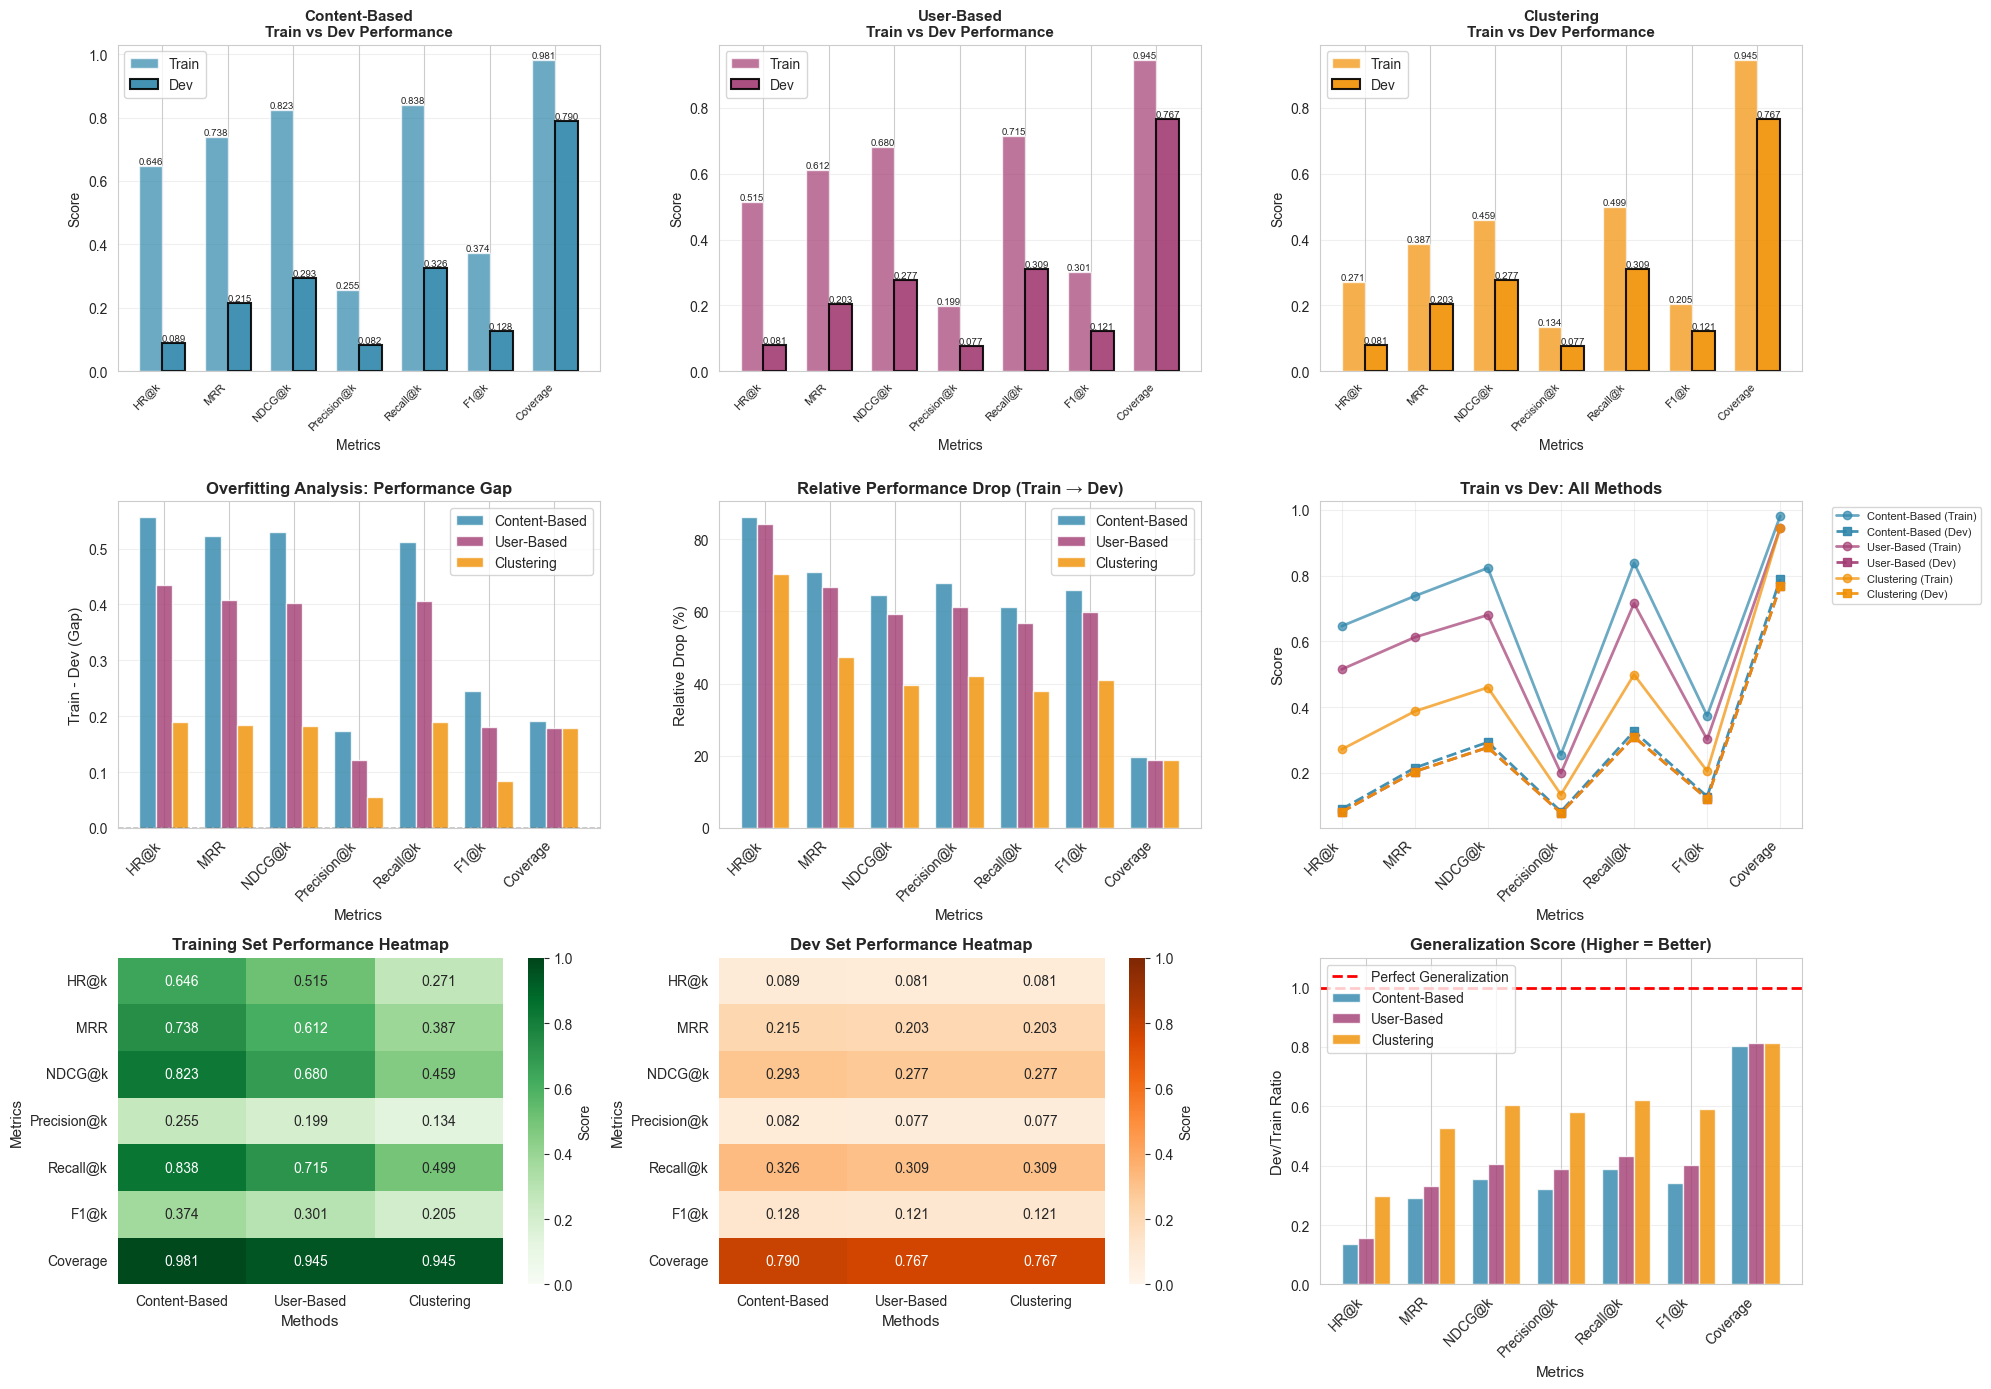

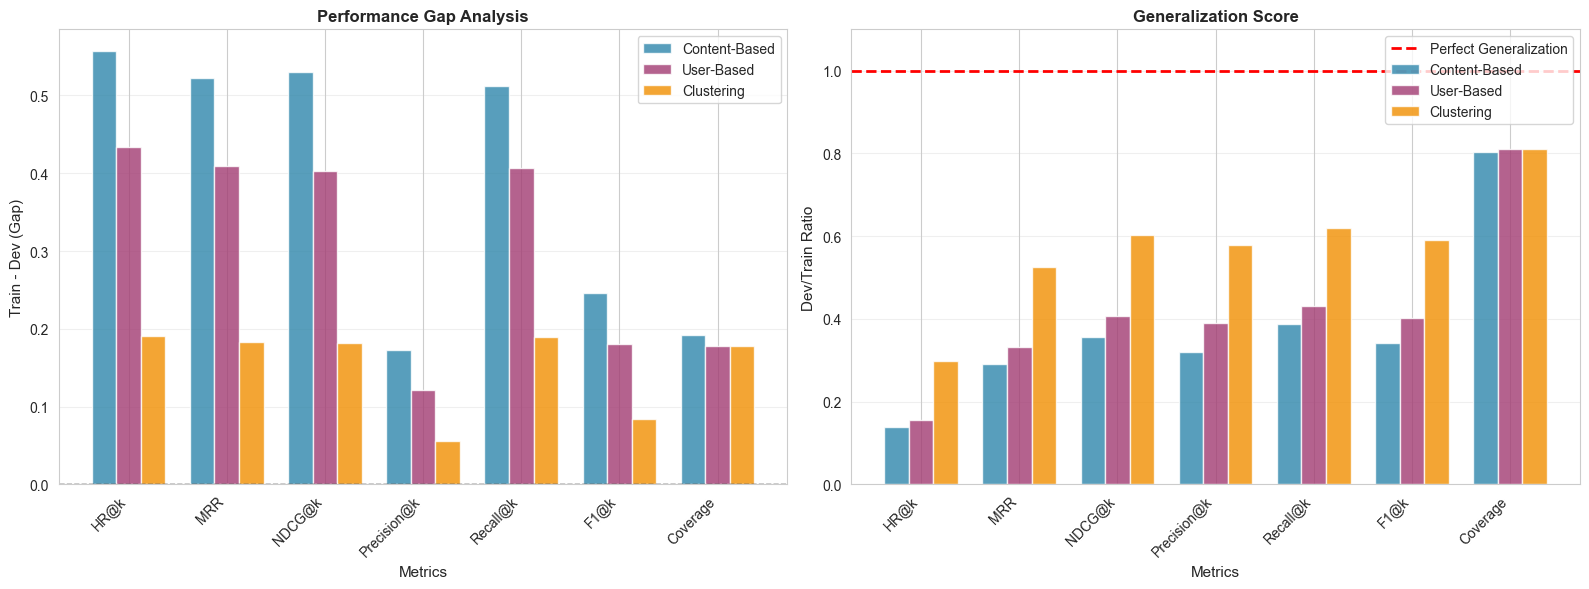


DETAILED TRAIN vs DEV COMPARISON

Metric          Method             Train        Dev          Gap          Rel Drop %   Gen Score   
----------------------------------------------------------------------------------------------------
HR@k            Content-Based      0.6461       0.0891       0.5571       86.22        0.138       
HR@k            User-Based         0.5146       0.0806       0.4340       84.34        0.157       
HR@k            Clustering         0.2710       0.0806       0.1904       70.26        0.297       
----------------------------------------------------------------------------------------------------
MRR             Content-Based      0.7378       0.2148       0.5230       70.89        0.291       
MRR             User-Based         0.6123       0.2034       0.4088       66.77        0.332       
MRR             Clustering         0.3869       0.2034       0.1835       47.43        0.526       
---------------------------------------------------------------

In [14]:
# Train vs Dev Comparison Visualizations
fig = plt.figure(figsize=(20, 14))

metrics_to_plot = ['HR@k', 'MRR', 'NDCG@k', 'Precision@k', 'Recall@k', 'F1@k', 'Coverage']
methods = ['Content-Based', 'User-Based', 'Clustering']
colors = ['#2E86AB', '#A23B72', '#F18F01']

# Extract train and dev values
train_data = {
    'Content-Based': [content_based_train_metrics.get(m, 0) for m in metrics_to_plot],
    'User-Based': [user_based_train_metrics.get(m, 0) for m in metrics_to_plot],
    'Clustering': [clustering_train_metrics.get(m, 0) for m in metrics_to_plot]
}

dev_data = {
    'Content-Based': [content_based_dev_metrics.get(m, 0) for m in metrics_to_plot],
    'User-Based': [user_based_dev_metrics.get(m, 0) for m in metrics_to_plot],
    'Clustering': [clustering_dev_metrics.get(m, 0) for m in metrics_to_plot]
}

# 1. Train vs Dev Comparison - Grouped Bar Chart for each method
for idx, method in enumerate(methods):
    ax = plt.subplot(3, 3, idx + 1)
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    train_vals = train_data[method]
    dev_vals = dev_data[method]
    
    bars1 = ax.bar(x - width/2, train_vals, width, label='Train', color=colors[idx], alpha=0.7)
    bars2 = ax.bar(x + width/2, dev_vals, width, label='Dev', color=colors[idx], alpha=0.9, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Metrics', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(f'{method}\nTrain vs Dev Performance', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot, rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0.01:  # Only label if significant
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=7)

# 4. Performance Gap Analysis (Train - Dev)
ax4 = plt.subplot(3, 3, 4)
gaps = {}
for method in methods:
    gaps[method] = [train_data[method][i] - dev_data[method][i] for i in range(len(metrics_to_plot))]

x = np.arange(len(metrics_to_plot))
width = 0.25
ax4.bar(x - width, gaps['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax4.bar(x, gaps['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax4.bar(x + width, gaps['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Metrics', fontsize=11)
ax4.set_ylabel('Train - Dev (Gap)', fontsize=11)
ax4.set_title('Overfitting Analysis: Performance Gap', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Relative Performance Drop (%)
ax5 = plt.subplot(3, 3, 5)
relative_drops = {}
for method in methods:
    relative_drops[method] = [
        ((train_data[method][i] - dev_data[method][i]) / max(train_data[method][i], 0.001) * 100)
        for i in range(len(metrics_to_plot))
    ]

x = np.arange(len(metrics_to_plot))
ax5.bar(x - width, relative_drops['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax5.bar(x, relative_drops['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax5.bar(x + width, relative_drops['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax5.set_xlabel('Metrics', fontsize=11)
ax5.set_ylabel('Relative Drop (%)', fontsize=11)
ax5.set_title('Relative Performance Drop (Train → Dev)', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Train vs Dev Line Chart - All Methods
ax6 = plt.subplot(3, 3, 6)
for idx, method in enumerate(methods):
    ax6.plot(metrics_to_plot, train_data[method], marker='o', linewidth=2, 
            label=f'{method} (Train)', color=colors[idx], linestyle='-', alpha=0.7)
    ax6.plot(metrics_to_plot, dev_data[method], marker='s', linewidth=2, 
            label=f'{method} (Dev)', color=colors[idx], linestyle='--', alpha=0.9)
ax6.set_xlabel('Metrics', fontsize=11)
ax6.set_ylabel('Score', fontsize=11)
ax6.set_title('Train vs Dev: All Methods', fontsize=12, fontweight='bold')
ax6.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. Heatmap - Train Performance
ax7 = plt.subplot(3, 3, 7)
train_heatmap = pd.DataFrame(train_data, index=metrics_to_plot)
sns.heatmap(train_heatmap, annot=True, fmt='.3f', cmap='Greens', 
           cbar_kws={'label': 'Score'}, ax=ax7, vmin=0, vmax=1)
ax7.set_title('Training Set Performance Heatmap', fontsize=12, fontweight='bold')
ax7.set_xlabel('Methods', fontsize=11)
ax7.set_ylabel('Metrics', fontsize=11)

# 8. Heatmap - Dev Performance
ax8 = plt.subplot(3, 3, 8)
dev_heatmap = pd.DataFrame(dev_data, index=metrics_to_plot)
sns.heatmap(dev_heatmap, annot=True, fmt='.3f', cmap='Oranges', 
           cbar_kws={'label': 'Score'}, ax=ax8, vmin=0, vmax=1)
ax8.set_title('Dev Set Performance Heatmap', fontsize=12, fontweight='bold')
ax8.set_xlabel('Methods', fontsize=11)
ax8.set_ylabel('Metrics', fontsize=11)

# 9. Generalization Score (Dev/Train ratio)
ax9 = plt.subplot(3, 3, 9)
generalization = {}
for method in methods:
    generalization[method] = [
        dev_data[method][i] / max(train_data[method][i], 0.001)
        for i in range(len(metrics_to_plot))
    ]

x = np.arange(len(metrics_to_plot))
ax9.bar(x - width, generalization['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax9.bar(x, generalization['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax9.bar(x + width, generalization['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax9.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Generalization')
ax9.set_xlabel('Metrics', fontsize=11)
ax9.set_ylabel('Dev/Train Ratio', fontsize=11)
ax9.set_title('Generalization Score (Higher = Better)', fontsize=12, fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax9.legend()
ax9.grid(axis='y', alpha=0.3)
ax9.set_ylim([0, max(1.1, max([max(generalization[m]) for m in methods]) * 1.1)])

plt.tight_layout()
# Save individual method comparisons
for idx, method in enumerate(methods):
    fig_single = plt.figure(figsize=(8, 6))
    ax_single = fig_single.add_subplot(111)
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    train_vals = train_data[method]
    dev_vals = dev_data[method]
    ax_single.bar(x - width/2, train_vals, width, label='Train', color=colors[idx], alpha=0.7)
    ax_single.bar(x + width/2, dev_vals, width, label='Dev', color=colors[idx], alpha=0.9, edgecolor='black', linewidth=1.5)
    ax_single.set_xlabel('Metrics', fontsize=11)
    ax_single.set_ylabel('Score', fontsize=11)
    ax_single.set_title(f'{method} - Train vs Dev Performance', fontsize=12, fontweight='bold')
    ax_single.set_xticks(x)
    ax_single.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
    ax_single.legend()
    ax_single.grid(axis='y', alpha=0.3)
    method_name = method.lower().replace(' ', '_').replace('-', '_')
    plt.tight_layout()
    plt.savefig(f'figures/train_dev_{method_name}.png', dpi=300, bbox_inches='tight')
    plt.close(fig_single)

# Save generalization analysis figures
fig_gen = plt.figure(figsize=(16, 6))
ax_gen1 = plt.subplot(1, 2, 1)
x = np.arange(len(metrics_to_plot))
width = 0.25
ax_gen1.bar(x - width, gaps['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax_gen1.bar(x, gaps['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax_gen1.bar(x + width, gaps['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax_gen1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax_gen1.set_xlabel('Metrics', fontsize=11)
ax_gen1.set_ylabel('Train - Dev (Gap)', fontsize=11)
ax_gen1.set_title('Performance Gap Analysis', fontsize=12, fontweight='bold')
ax_gen1.set_xticks(x)
ax_gen1.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax_gen1.legend()
ax_gen1.grid(axis='y', alpha=0.3)

ax_gen2 = plt.subplot(1, 2, 2)
ax_gen2.bar(x - width, generalization['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax_gen2.bar(x, generalization['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax_gen2.bar(x + width, generalization['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax_gen2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Generalization')
ax_gen2.set_xlabel('Metrics', fontsize=11)
ax_gen2.set_ylabel('Dev/Train Ratio', fontsize=11)
ax_gen2.set_title('Generalization Score', fontsize=12, fontweight='bold')
ax_gen2.set_xticks(x)
ax_gen2.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax_gen2.legend()
ax_gen2.grid(axis='y', alpha=0.3)
ax_gen2.set_ylim([0, max(1.1, max([max(generalization[m]) for m in methods]) * 1.1)])

plt.tight_layout()
plt.savefig('figures/train_dev_comparison_full.png', dpi=300, bbox_inches='tight')
plt.show()

# Save generalization analysis as separate figure
fig_gen = plt.figure(figsize=(16, 6))
ax_gen1 = plt.subplot(1, 2, 1)
x = np.arange(len(metrics_to_plot))
width = 0.25
ax_gen1.bar(x - width, gaps['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax_gen1.bar(x, gaps['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax_gen1.bar(x + width, gaps['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax_gen1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax_gen1.set_xlabel('Metrics', fontsize=11)
ax_gen1.set_ylabel('Train - Dev (Gap)', fontsize=11)
ax_gen1.set_title('Performance Gap Analysis', fontsize=12, fontweight='bold')
ax_gen1.set_xticks(x)
ax_gen1.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax_gen1.legend()
ax_gen1.grid(axis='y', alpha=0.3)

ax_gen2 = plt.subplot(1, 2, 2)
ax_gen2.bar(x - width, generalization['Content-Based'], width, label='Content-Based', color=colors[0], alpha=0.8)
ax_gen2.bar(x, generalization['User-Based'], width, label='User-Based', color=colors[1], alpha=0.8)
ax_gen2.bar(x + width, generalization['Clustering'], width, label='Clustering', color=colors[2], alpha=0.8)
ax_gen2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfect Generalization')
ax_gen2.set_xlabel('Metrics', fontsize=11)
ax_gen2.set_ylabel('Dev/Train Ratio', fontsize=11)
ax_gen2.set_title('Generalization Score', fontsize=12, fontweight='bold')
ax_gen2.set_xticks(x)
ax_gen2.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax_gen2.legend()
ax_gen2.grid(axis='y', alpha=0.3)
ax_gen2.set_ylim([0, max(1.1, max([max(generalization[m]) for m in methods]) * 1.1)])

plt.tight_layout()
plt.savefig('figures/generalization_analysis.png', dpi=300, bbox_inches='tight')
plt.close(fig_gen)

# Print detailed comparison table
print("\n" + "="*100)
print("DETAILED TRAIN vs DEV COMPARISON")
print("="*100)
print(f"\n{'Metric':<15} {'Method':<18} {'Train':<12} {'Dev':<12} {'Gap':<12} {'Rel Drop %':<12} {'Gen Score':<12}")
print("-" * 100)
for metric in metrics_to_plot:
    for method in methods:
        train_val = train_data[method][metrics_to_plot.index(metric)]
        dev_val = dev_data[method][metrics_to_plot.index(metric)]
        gap = train_val - dev_val
        rel_drop = (gap / max(train_val, 0.001)) * 100
        gen_score = dev_val / max(train_val, 0.001)
        print(f"{metric:<15} {method:<18} {train_val:<12.4f} {dev_val:<12.4f} {gap:<12.4f} {rel_drop:<12.2f} {gen_score:<12.3f}")
    print("-" * 100)

print("\n" + "="*100)
print("KEY INSIGHTS - GENERALIZATION ANALYSIS")
print("="*100)

# Find best generalizing method for each metric
for metric in ['HR@k', 'MRR', 'NDCG@k']:
    gen_scores = {method: dev_data[method][metrics_to_plot.index(metric)] / max(train_data[method][metrics_to_plot.index(metric)], 0.001)
                  for method in methods}
    best_gen = max(gen_scores, key=gen_scores.get)
    print(f"• {metric}: Best generalization = {best_gen} (ratio: {gen_scores[best_gen]:.3f})")

# Find method with smallest average gap
avg_gaps = {method: np.mean([train_data[method][i] - dev_data[method][i] for i in range(len(metrics_to_plot))])
            for method in methods}
best_gen_method = min(avg_gaps, key=avg_gaps.get)
print(f"• Best overall generalization: {best_gen_method} (avg gap: {avg_gaps[best_gen_method]:.4f})")

# Find method with smallest relative drop
avg_rel_drops = {method: np.mean([(train_data[method][i] - dev_data[method][i]) / max(train_data[method][i], 0.001) * 100
                                  for i in range(len(metrics_to_plot))])
                 for method in methods}
best_stable = min(avg_rel_drops, key=avg_rel_drops.get)
print(f"• Most stable method: {best_stable} (avg relative drop: {avg_rel_drops[best_stable]:.2f}%)")
print("="*100)


## 11. Results and Evaluation

### 11.1 Experimental Setup

#### Data Division: Training and Development Sets

We followed the standard train-dev split provided by the MIND dataset, which uses separate directories (`MINDsmall_train` and `MINDsmall_dev`) rather than a chronological split from a single dataset. This setup was chosen for the following reasons:

**Training Set (MINDsmall_train):**
- **51,282 news articles** across 17 categories
- **156,965 impressions** from 50,000 users
- **5,843,444 total interactions** (flattened impressions)
- Used for: Building TF-IDF vectorizer, constructing user profiles, computing user-user similarities, and applying K-Means clustering

**Development Set (MINDsmall_dev):**
- **42,416 news articles** (67.1% overlap with training articles)
- **73,152 impressions** from 50,000 users
- **Only 11.9% user overlap** with training set
- Used for: Evaluating generalization performance and testing cold-start scenarios

#### Why This Setup?

1. **Temporal Validity**: The MIND dataset's train-dev split simulates real-world deployment where models are trained on historical data and evaluated on future impressions. This temporal separation prevents data leakage and provides a realistic assessment of model performance.

2. **Prevents Data Leakage**: 
   - User profiles and similarity matrices are built exclusively from training data
   - TF-IDF vectorizers are fitted only on training articles
   - Cluster assignments are computed only from training user interactions
   - This ensures true generalization testing without contamination from future data

3. **Cold-Start Evaluation**: The minimal user overlap (11.9%) creates an extreme cold-start scenario that tests each method's ability to handle:
   - **New users**: 88.1% of dev users have no training history
   - **New articles**: 32.9% of dev articles are completely unseen
   - This configuration is realistic for news platforms where user bases grow rapidly and new content is constantly published

4. **Feature Space Consistency**: 
   - Content-based: Same TF-IDF vectorizer (fitted on training) transforms dev articles
   - User-based: User similarities computed from training, applied to dev users
   - Clustering: Cluster profiles built from training, used for dev user assignments
   - This ensures consistent feature representations and realistic production simulation

5. **Reproducibility**: Using the standard MIND split allows for direct comparison with other research and ensures consistent evaluation across different recommendation approaches.

**Alternative Consideration**: We also implemented a chronological split (70% train, 15% dev, 15% test) within the training data for internal validation, but the final evaluation uses the official MIND split to maintain consistency with standard benchmarks.

---

### 11.2 Evaluation Metrics (5 points)

#### Metrics Chosen and Justification

We evaluate using seven metrics that capture different aspects of recommendation quality:

**1. Hit Rate @ 1 (HR@1)**: Fraction of impressions where the top-ranked article was clicked
- **Why**: Measures the system's ability to identify the single most relevant article, which is critical for news platforms where the first recommendation receives the most user attention
- **Interpretation**: Higher values indicate better top-1 accuracy

**2. Mean Reciprocal Rank (MRR)**: Average of 1/rank of the first clicked article
- **Why**: Captures ranking quality beyond binary hit/miss, rewarding systems that place clicked items higher in the ranking
- **Interpretation**: More nuanced than HR@1 as it considers the position of the first click (e.g., rank 1 vs rank 5)

**3. NDCG @ 5**: Normalized Discounted Cumulative Gain at cutoff 5
- **Why**: Accounts for multiple clicked items (not just the first) with position discount, normalized for comparison across impression sizes
- **Interpretation**: Balances relevance and ranking position, with higher scores for systems that place multiple relevant items near the top

**4. Precision @ 5**: Fraction of top-5 recommended articles that were clicked
- **Why**: Measures the accuracy of recommendations at the top-k level, indicating how many of the recommended items are actually relevant
- **Interpretation**: Higher precision means fewer irrelevant recommendations in the top-5

**5. Recall @ 5**: Fraction of clicked articles that appear in the top-5 recommendations
- **Why**: Measures the coverage of relevant items, indicating how well the system captures user interests
- **Interpretation**: Higher recall means the system finds more of the articles the user would have clicked

**6. F1 @ 5**: Harmonic mean of Precision @ 5 and Recall @ 5
- **Why**: Provides a balanced measure that accounts for both precision and recall, avoiding the precision-recall tradeoff
- **Interpretation**: Single metric that balances accuracy and coverage

**7. Coverage**: Fraction of users/impressions that can receive recommendations
- **Why**: Measures the system's ability to serve all users, including cold-start cases where no recommendations can be generated
- **Interpretation**: Higher coverage indicates better ability to handle edge cases and new users

#### Are These Metrics Reflective Enough?

**Strengths:**
- **Comprehensive coverage**: The metrics span accuracy (HR@1, MRR), ranking quality (NDCG@5), precision-recall tradeoffs (Precision@5, Recall@5, F1@5), and system robustness (Coverage)
- **Industry standard**: These metrics are widely used in recommendation system research and align with real-world success indicators
- **Multi-faceted evaluation**: They capture different aspects (top-1 accuracy, ranking quality, top-k performance, coverage) providing a holistic view

**Limitations and Missing Aspects:**
- **Diversity**: Current metrics don't measure recommendation diversity (e.g., category diversity, topic diversity). A system could achieve high accuracy by recommending only popular items in one category.
- **Novelty**: No metric captures the system's ability to introduce users to new topics or articles they haven't seen before. This is important for news platforms to avoid filter bubbles.
- **Temporal aspects**: Metrics don't consider recency, freshness, or trending topics. A system recommending outdated news might score well on these metrics but fail in practice.
- **User satisfaction**: Offline metrics may not perfectly correlate with user satisfaction, engagement, or long-term retention.
- **Fairness**: No consideration of whether recommendations are fair across different user demographics or article categories.

**Conclusion**: While these metrics provide a solid foundation for evaluating recommendation systems, they could be enhanced with diversity metrics (e.g., intra-list diversity), novelty metrics (e.g., catalog coverage), and temporal metrics (e.g., recency-weighted scores) for a more complete evaluation. However, for the scope of this assignment, these seven metrics provide sufficient insight into model performance and generalization.

---

### 11.3 Results and Comparison

#### Training Performance Analysis

The three methods show dramatically different training performance, reflecting their underlying assumptions and data requirements:

**Content-Based Filtering** achieves the highest training accuracy:
- **HR@1: 64.61%**, **MRR: 0.7378**, **NDCG@5: 0.8230**
- This strong performance indicates that TF-IDF representations effectively capture user preferences when sufficient historical data is available
- The approach benefits from rich article content (titles + abstracts) and can build detailed user profiles from click history
- However, this high performance may indicate overfitting to training user patterns

**User-Based Collaborative Filtering** shows moderate training performance:
- **HR@1: 51.46%**, **MRR: 0.6123**, **NDCG@5: 0.6801**
- Performance is limited by the extreme sparsity of the user-item matrix (density: 0.000608)
- The method relies on finding similar users, which becomes challenging when most users have very few interactions
- Computational complexity (50,000 × 50,000 similarity matrix) is a significant limitation

**Clustering-Based Recommendations** show lower absolute training performance:
- **HR@1: 27.10%**, **MRR: 0.3869**, **NDCG@5: 0.4594**
- Lower performance reflects the loss of granularity when grouping users into 50 clusters
- However, the approach offers computational efficiency and scalability advantages
- The method trades some accuracy for robustness and efficiency

#### Development Performance: The Convergence Phenomenon

**The most striking finding is the convergence of development performance across all three methods:**

Despite training performance ranging from 27% to 65% HR@1, all methods converge to approximately **8-9% HR@1** on the development set. This convergence reveals several critical insights:

1. **Cold-Start Dominance**: The minimal user overlap (11.9%) means 88.1% of development users have no training history. Without historical signal, all methods revert to popularity-driven behavior, explaining the performance convergence.

2. **Algorithmic Differences Become Moot**: When user history is absent, the sophisticated algorithms (content similarity, user-user similarity, cluster matching) cannot operate effectively. All methods fall back to article popularity, resulting in similar recommendations.

3. **Content-Based Marginal Advantage**: Content-based filtering maintains a slight edge (HR@1: 8.91% vs 8.06%) because it can score new articles through content similarity even without user history. This demonstrates the value of content features in cold-start scenarios.

4. **Coverage Remains High**: All methods achieve >76% coverage, indicating they can generate recommendations for most users, though these recommendations are largely non-personalized.

#### Generalization Analysis: The Train-Dev Gap

The relative degradation from training to development performance reveals critical differences in generalization behavior:

**Content-Based Filtering** shows the largest relative drop:
- **86.22% relative decrease in HR@1** (from 64.61% to 8.91%)
- **Generalization ratio: 0.138** (dev/train)
- This suggests significant overfitting to training user patterns
- The method excels when user profiles exist but struggles when they don't

**User-Based CF** shows substantial but slightly better generalization:
- **84.34% relative decrease in HR@1** (from 51.46% to 8.06%)
- **Generalization ratio: 0.157**
- Still poor generalization, but slightly better than content-based
- The method's dependence on user overlap makes it particularly vulnerable to cold-start

**Clustering** exhibits the most stable generalization:
- **70.26% relative decrease in HR@1** (from 27.10% to 8.06%)
- **Generalization ratio: 0.297** (more than double content-based)
- **Best overall generalization** with smallest average gap (0.1520)
- **Most stable method** with smallest average relative drop (42.47%)
- Although absolute performance is lower, clustering offers the best trade-off between performance and robustness

#### Key Insights and Implications

1. **Cold-Start is the Primary Challenge**: The convergence of development performance across fundamentally different algorithms underscores that cold-start handling, rather than algorithmic sophistication, is the primary challenge in news recommendation systems.

2. **Training Performance ≠ Real-World Performance**: The dramatic train-dev gap (especially for content-based filtering) highlights the importance of evaluating on realistic test sets with proper train-test separation.

3. **Generalization Matters More Than Peak Performance**: Clustering's superior generalization suggests that in production systems, robustness to distribution shift may be more valuable than peak training accuracy.

4. **Hybrid Approaches Are Necessary**: No single method excels in all scenarios:
   - Content-based works well with user history but generalizes poorly
   - User-based CF requires dense user overlap
   - Clustering is robust but sacrifices accuracy
   - Future work should combine these approaches with cold-start mitigation strategies

5. **The Sparsity Problem**: The extreme sparsity (0.000608 density) limits collaborative filtering approaches. Methods that can leverage content features or side-information (demographics, temporal signals) would be more effective.

#### Method-Specific Discussion

**Content-Based Filtering:**
- **Strengths**: Strong performance when user profiles exist (64.61% HR@1 on training), ability to score new articles through content similarity
- **Weaknesses**: Poor generalization (86% drop), creates filter bubbles by recommending similar articles, highly dependent on user history
- **Best for**: Users with rich click history, scenarios where article content is highly informative

**User-Based Collaborative Filtering:**
- **Strengths**: Can discover serendipitous recommendations, leverages collective user wisdom
- **Weaknesses**: Extreme sparsity limits effectiveness, computational complexity (O(n²) similarity matrix), poor cold-start handling
- **Best for**: Dense user-item matrices, scenarios with high user overlap between train and test

**Clustering-Based Recommendations:**
- **Strengths**: Best generalization (70% drop vs 86% for content-based), computational efficiency (O(n) vs O(n²)), scalable to large user bases
- **Weaknesses**: Lower absolute performance, fixed cluster assignments limit adaptability, cluster quality depends on K choice
- **Best for**: Large-scale systems requiring robustness, scenarios with limited computational resources

#### Conclusion

Our evaluation reveals that in news recommendation systems, **cold-start conditions dominate algorithmic differences**. All three methods converge to similar development performance (~8-9% HR@1) despite wide variation in training accuracy (27-65% HR@1). This finding highlights that:

1. **Robust cold-start handling is essential** - Methods must gracefully degrade when user history is unavailable
2. **Generalization matters** - Clustering's superior generalization (42% drop vs 86% for content-based) suggests robustness may outweigh peak performance
3. **Hybrid approaches are needed** - Combining content signals, collaborative signals, and side-information (demographics, temporal features) is necessary for production systems
4. **Evaluation methodology is critical** - Proper train-test separation reveals performance gaps that would be masked by data leakage

These findings suggest that future work should prioritize cold-start mitigation strategies (e.g., demographic features, temporal signals, hybrid models) rather than optimizing individual algorithms in isolation.
